# Organizational Network Analysis: Identifying Leaders and Opinion-Makers

## Introduction

This analysis explores internal communication patterns in a student cohort using self-reported email data. The goal is to identify key individuals who influence information flow, distinguish between initiators and leaders, and uncover structural insights using network analysis.

In our analysis of the organizational network, we begin by examining the "Sent" sheet, focusing solely on outgoing edges to understand the individuals who actively initiate communication. By analyzing only out-degree centrality in this sheet, we aim to identify those who frequently reach out to others, playing a key role in spreading information and shaping discussions. These individuals are likely to be proactive communicators, opinion-makers, or key facilitators of knowledge exchange within the cohort.

We then shift our focus to the "Received" sheet, considering only in-degree centrality to determine who receives the most communication from their peers. While in theory, the "Sent" and "Received" matrices should be symmetric, discrepancies arise in our dataset, making it essential to analyze them separately. By distinguishing between outgoing and incoming interactions, we can more effectively identify not only those who drive discussions but also those who hold influence by being sought after, ultimately helping us differentiate between opinion-makers and authoritative leaders.

## Outgoing Communication Patterns

### Data Cleaning & Preprocessing

In [148]:
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

file_path = "who_talks_to_whom.xlsx"
xls = pd.ExcelFile(file_path)

sent_df = xls.parse("Sent")

sent_df = sent_df.replace('-', np.nan).infer_objects(copy=False)
pd.set_option('future.no_silent_downcasting', True)
sent_df.iloc[:, 1:] = sent_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

Thus, first, we loaded the dataset and processed the "Sent" sheet. We found dashes ("-") in the adjacency matrix, representing missing values, so we replaced them with NaN. To ensure numerical consistency for network analysis, we converted all values to numeric, using `pd.to_numeric(errors='coerce')` to handle any remaining non-numeric entries.

### Exploratory Data Analysis (EDA)

In [151]:
def adjacency_to_edgelist(df):
    edges = []
    nodes = df.iloc[:, 0].tolist()
    df_values = df.iloc[:, 1:].values

    for i, sender in enumerate(nodes):
        for j, receiver in enumerate(nodes):
            weight = df_values[i, j]
            if not (np.isnan(weight) or weight == 0):
                edges.append((sender, receiver, weight))

    return edges

edges_sent = adjacency_to_edgelist(sent_df)

G_sent = nx.DiGraph()
G_sent.add_weighted_edges_from(edges_sent)

print(f"Graph has {G_sent.number_of_nodes()} nodes and {G_sent.number_of_edges()} edges")

Graph has 81 nodes and 2046 edges


We converted the adjacency matrix from the "Sent" sheet into an edge list and created a directed graph in NetworkX. Each row and column in the matrix represent individuals, and the values indicate the number of messages exchanged. We extracted this data, ignoring missing (NaN) or zero values, and stored it as weighted edges in a list.

Using this edge list, we constructed a directed graph (DiGraph), where each edge represents a communication instance between two individuals. Finally, we printed the number of nodes (81) and edges (2046) to confirm the structure of the network.

In [153]:
if not nx.is_strongly_connected(G_sent):
    largest_scc = max(nx.strongly_connected_components(G_sent), 
                      key=len)
    G_scc = G_sent.subgraph(largest_scc).copy()
    print(f"Graph is not strongly connected. Using largest SCC with {len(G_scc.nodes())} nodes.")
else:
    G_scc = G_sent

out_degree_centrality = nx.out_degree_centrality(G_sent) 
eigenvector_centrality = nx.eigenvector_centrality_numpy(G_scc, 
                                                         weight="weight")  
betweenness_centrality = nx.betweenness_centrality(G_sent, 
                                                   weight="weight")  
out_closeness_centrality = nx.closeness_centrality(G_sent)  
clustering_coefficient = nx.clustering(G_sent.to_undirected(), 
                                       weight="weight") 

for node in G_sent.nodes():
    if node not in eigenvector_centrality:
        eigenvector_centrality[node] = 0

centrality_df = pd.DataFrame({
    "Out-Degree Centrality": out_degree_centrality,
    "Eigenvector Centrality": eigenvector_centrality,
    "Betweenness Centrality": betweenness_centrality,
    "Out-Closeness Centrality": out_closeness_centrality,
    "Clustering Coefficient": clustering_coefficient
})

Graph is not strongly connected. Using largest SCC with 80 nodes.


### Network Analysis

Next, we focus on computing key centrality measures and the clustering coefficient for the "Sent" network, considering only outgoing connections to identify individuals who proactively initiate communication.

Since the graph is not strongly connected, we first extract the largest strongly connected component (SCC) to ensure that eigenvector centrality is computed meaningfully. This metric measures a node’s influence based on the importance of its connections, meaning that nodes in isolated or weakly connected components will not provide reliable influence scores.

The objective of this analysis is to identify opinion-makers within the cohort, individuals who actively shape discussions by reaching out to multiple others. A person who only interacts within a small, isolated group cannot be considered an overall opinion leader, as their influence remains confined to a limited subset of the cohort. Extracting the largest SCC ensures that we analyze influence within the most interconnected part of the network, rather than including individuals who do not significantly contribute to broader communication patterns.

For nodes that do not belong to the largest SCC, we assign them an eigenvector centrality value of zero, as they are disconnected from the primary communication flow. This aligns with our goal of identifying individuals who play a crucial role in the wider network, rather than those whose influence is restricted to small, fragmented groups.

Thus, we calculate the following centrality measures, with a primary focus on out-degree-based influence:

- Out-Degree Centrality: Measures direct influence based on the number of individuals a person reaches out to.
- Eigenvector Centrality: Captures indirect influence by considering the importance of connected nodes (computed only on the largest SCC).
- Betweenness Centrality: Identifies nodes that act as bridges controlling information flow across different subgroups.
- Out-Closeness Centrality: Measures how efficiently a node can spread information to others in the network.

Additionally, we compute the clustering coefficient, which quantifies how well a node’s neighbors are interconnected, helping to identify locally influential individuals who form tightly-knit groups.

While some of these centrality measures do not inherently distinguish between incoming and outgoing connections (such as betweenness centrality and clustering coefficient), they still provide valuable insights into the overall network structure and communication flow. For this reason, we include them in our analysis, complementing our primary focus on out-degree influence in the "Sent" network.

Finally, all these metrics are normalized and stored in a structured DataFrame, allowing for a systematic ranking of the most influential individuals in the Sent communication network.


In [156]:
top_5_df = pd.DataFrame({
    "Top 5 by Out-Degree": centrality_df["Out-Degree Centrality"].nlargest(5).index,
    "Out-Degree Centrality": centrality_df["Out-Degree Centrality"].nlargest(5).values,
    "Top 5 by Eigenvector": centrality_df["Eigenvector Centrality"].nlargest(5).index,
    "Eigenvector Centrality": centrality_df["Eigenvector Centrality"].nlargest(5).values,
    "Top 5 by Betweenness": centrality_df["Betweenness Centrality"].nlargest(5).index,
    "Betweenness Centrality": centrality_df["Betweenness Centrality"].nlargest(5).values,
    "Top 5 by Out-Closeness": centrality_df["Out-Closeness Centrality"].nlargest(5).index,
    "Out-Closeness Centrality": centrality_df["Out-Closeness Centrality"].nlargest(5).values,
    "Top 5 by Clustering": centrality_df["Clustering Coefficient"].nlargest(5).index,
    "Clustering Coefficient": centrality_df["Clustering Coefficient"].nlargest(5).values
})

print(top_5_df)


   Top 5 by Out-Degree  Out-Degree Centrality  Top 5 by Eigenvector  \
0                   22                 0.6125                    19   
1                   32                 0.5500                    69   
2                   47                 0.5250                    12   
3                   62                 0.5250                    39   
4                   42                 0.5125                    60   

   Eigenvector Centrality  Top 5 by Betweenness  Betweenness Centrality  \
0                0.342339                    78                0.100306   
1                0.296211                    32                0.069951   
2                0.279053                     4                0.058756   
3                0.246914                    44                0.055520   
4                0.223972                    53                0.050497   

   Top 5 by Out-Closeness  Out-Closeness Centrality  Top 5 by Clustering  \
0                      14                  0.6

The table displays the top five nodes for each centrality measure along with their corresponding values, offering different perspectives on influence within the network.

- Out-Degree Centrality highlights individuals who have the most outgoing connections. Nodes 22, 32, and 47 rank the highest, indicating that they are the most proactive in initiating communication within the network. Their high out-degree suggests they are likely opinion-makers who actively engage in spreading information.
- Eigenvector Centrality identifies nodes that are well-connected to other influential individuals. Nodes 19, 69, and 12 are the most prominent in this regard, suggesting that they maintain strong ties with other central figures and play a role in amplifying information across the network.
- Betweenness Centrality measures how often a node serves as a bridge between different parts of the network. Node 78 ranks highest, indicating that it plays a crucial role in facilitating communication flow and connecting otherwise distant groups.
- Out-Closeness Centrality assesses how efficiently a node can reach others in the network through outgoing paths. Nodes 14, 32, and 40 score the highest, meaning they are in advantageous positions for quickly disseminating information.
- Clustering Coefficient quantifies how well a node's neighbors are interconnected. Nodes 59, 20, and 43 exhibit the highest clustering coefficients, indicating strong local cohesion, where groups of nodes communicate closely within tightly-knit clusters.

While each centrality measure provides useful insights, relying on a single metric does not fully capture an individual’s influence within the cohort. For instance, a node with high out-degree centrality but low eigenvector centrality may initiate many conversations but lack strong connections to other influential individuals. Similarly, a high betweenness centrality score suggests an important intermediary role but does not necessarily mean a node has a large number of direct interactions.

To develop a comprehensive measure of influence, we propose using a weighted combination of all centrality measures. By assigning appropriate weights to each metric, we can balance the impact of direct communication (out-degree centrality), overall influence (eigenvector centrality), gatekeeping roles (betweenness centrality), efficiency in spreading information (out-closeness centrality), and local cohesion (clustering coefficient). This approach provides a holistic evaluation of leadership and influence in the network, enabling us to identify key opinion-makers and decision-leaders. The next step involves defining these weights and computing the custom influence score.














In [158]:
scaler = MinMaxScaler()
centrality_df_norm = pd.DataFrame(
    scaler.fit_transform(centrality_df), 
    columns=centrality_df.columns, 
    index=centrality_df.index
)

weights = {
    "Out-Degree Centrality": 0.30,  
    "Eigenvector Centrality": 0.35,  
    "Betweenness Centrality": 0.20,
    "Out-Closeness Centrality": 0.10,
    "Clustering Coefficient": 0.05
}

centrality_df_norm["Custom Influence Score"] = sum(
    centrality_df_norm[measure] * weight for measure, weight in weights.items()
)

top_influential = centrality_df_norm["Custom Influence Score"].nlargest(10)
print("Top 10 Most Influential Nodes Based on Custom Influence Score:")
print(top_influential)

Top 10 Most Influential Nodes Based on Custom Influence Score:
32    0.711054
19    0.635975
78    0.626825
12    0.612782
22    0.592721
73    0.584771
69    0.580031
68    0.548098
62    0.530271
39    0.498090
Name: Custom Influence Score, dtype: float64


Thus, we constructed a custom influence score based on multiple centrality measures. The weights were assigned strategically to reflect different aspects of influence in an organizational setting. Eigenvector centrality received the highest weight (0.35) as it captures indirect influence by considering connections to well-connected individuals. Out-degree centrality was weighted at 0.30, as direct communication volume remains essential in gauging network prominence and identifying proactive communicators. Betweenness centrality was assigned 0.20, given its role in identifying key intermediaries who facilitate communication between different groups. Out-closeness centrality, which measures how efficiently a node can reach others, received a weight of 0.10, while the clustering coefficient, reflecting local network cohesiveness, was given a moderate weight of 0.05.

The results indicate that Node 32 is the most influential in the cohort, followed by Nodes 19, 78, 12, and 22, identifying them as key opinion-makers within the group. These individuals hold strong positions in the network, exhibiting a combination of high connectivity, indirect influence, and a central role in information flow. Their prominence in multiple centrality measures reinforces their importance in shaping discussions and facilitating communication.

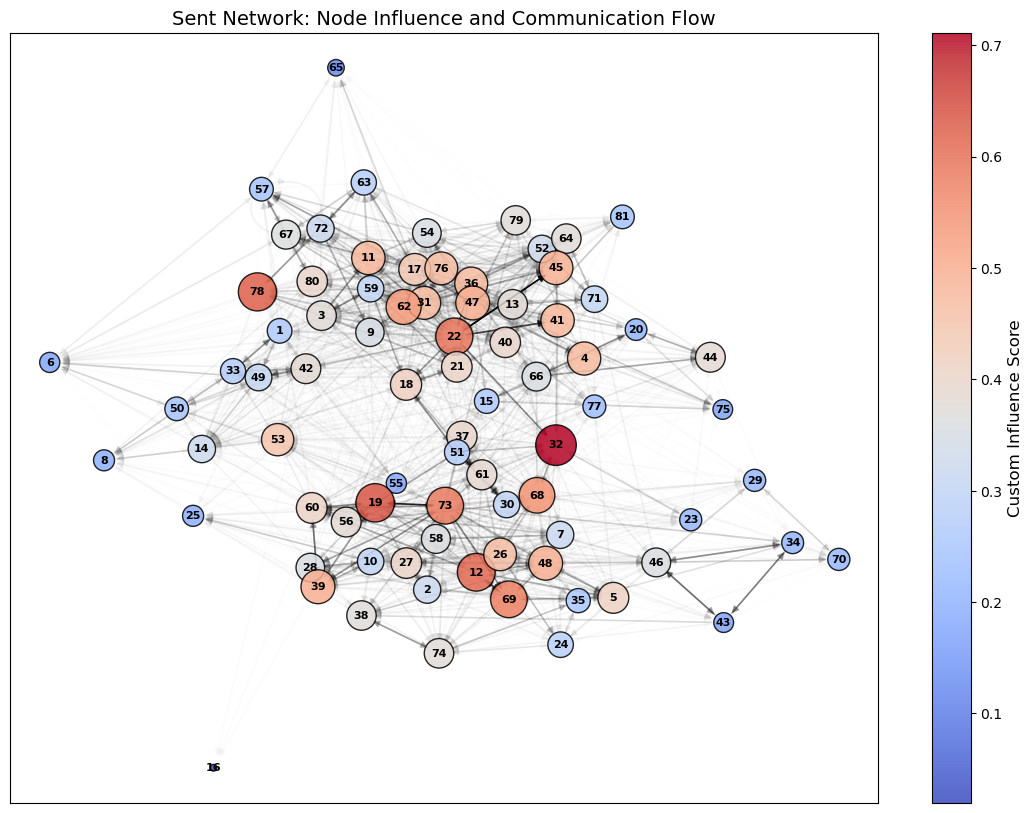

In [160]:
node_sizes = [centrality_df_norm.loc[node, "Custom Influence Score"] * 1200 for node in G_sent.nodes()]
node_colors = [centrality_df_norm.loc[node, "Custom Influence Score"] for node in G_sent.nodes()]

pos = nx.spring_layout(G_sent, k=1, seed=42)

plt.figure(figsize=(14, 10))

edges, weights = zip(*nx.get_edge_attributes(G_sent, 'weight').items())
max_weight = max(weights) if max(weights) > 0 else 1
edge_alphas = [w / max_weight for w in weights]

for edge, alpha in zip(edges, edge_alphas):
    nx.draw_networkx_edges(G_sent, pos, edgelist=[edge], alpha=alpha, edge_color="black", 
                           width=1.2)

sc = nx.draw_networkx_nodes(G_sent, pos, node_size=node_sizes, 
                            node_color=node_colors, cmap=plt.cm.coolwarm, 
                            alpha=0.85, edgecolors="black")

nx.draw_networkx_labels(G_sent, pos, labels={node: node for node in G_sent.nodes()}, 
                        font_size=8, font_weight="bold", font_color="black")

cbar = plt.colorbar(sc)
cbar.set_label("Custom Influence Score", fontsize=12)

plt.xlim(min(x for x, _ in pos.values()) * 1.1, max(x for x, _ in pos.values()) * 1.1)
plt.ylim(min(y for _, y in pos.values()) * 1.1, max(y for _, y in pos.values()) * 1.1)

plt.title("Sent Network: Node Influence and Communication Flow", fontsize=14)
plt.show()

### Insights & Interpretation

The visualization effectively highlights the most influential individuals in the cohort, with nodes colored from blue to red to indicate varying levels of influence. The larger and redder nodes represent the most central figures based on our custom influence score, which integrates multiple centrality measures, including out-degree, eigenvector, betweenness, out-closeness, and clustering coefficient. The edges vary in transparency, with darker edges indicating stronger communication ties, allowing us to observe the structural density and interaction intensity within the network.

From the plot, we can identify that Nodes 32, 19, 78, 12, and 22 emerge as the most influential individuals in the network. These individuals act as key opinion leaders, initiating conversations and facilitating the dissemination of information across the cohort. Their central positioning suggests they are highly connected, linking multiple groups and ensuring efficient information flow.

A notable feature of this network is the presence of two visibly distinct clusters, which indicate separate but interconnected communication groups within the cohort. Node 32 appears to serve as a key mediator between these clusters, bridging the gap between different subgroups and enabling the exchange of information between them. This reinforces the role of Node 32 as a crucial connector, ensuring that communication remains cohesive across the entire network.

A particularly interesting observation is Node 16, which remains an outlier in the network. Positioned far from the central clusters, it has minimal interaction with the rest of the cohort, suggesting limited engagement in overall communication dynamics. This isolation may indicate a peripheral role within the group or potentially a disengagement from key discussions. Understanding such nodes is essential in assessing overall communication efficiency and ensuring that vital members of the network are not excluded from important exchanges.

## Incoming Communication Patterns

Shifting our focus to the "Received" sheet, we now analyze individuals who are most frequently contacted by others. Unlike the "Sent" analysis, which highlighted those who initiate communication, the "Received" perspective focuses on those who are sought after for information, guidance, or leadership. By identifying individuals with high in-degree centrality, we can pinpoint key figures who may not actively initiate conversations but are nonetheless central to the network due to the volume of incoming communication they receive.

To ensure consistency, we follow the same analytical steps as in the "Sent" analysis—cleaning the data, constructing a directed graph, computing centrality measures, and applying our custom influence metric. However, for the "Received" sheet, we prioritize in-degree centrality, as it directly measures how often individuals are contacted by others. While other centrality metrics do not distinguish between in- and out-degree, we still include them to gain additional insights into network influence.

By comparing these findings with the "Sent" results, we can distinguish between proactive communicators (who initiate interactions) and passive influencers (who are frequently contacted but do not necessarily initiate conversations). This dual perspective allows us to better understand who holds authority within the cohort, attracts engagement, and serves as a focal point for incoming communication - the leaders.


###  Data Cleaning & Preprocessing

In [166]:
received_df = xls.parse("Received")

received_df.replace('-', np.nan, inplace=True)
received_df.iloc[:, 1:] = received_df.iloc[:, 1:].apply(pd.to_numeric, 
                                                        errors='coerce')

def adjacency_to_edgelist_received(df):
    edges = []
    nodes = df.iloc[:, 0].tolist()
    df_values = df.iloc[:, 1:].values

    for i, receiver in enumerate(nodes):  
        for j, sender in enumerate(nodes):  
            weight = df_values[i, j]
            if not (np.isnan(weight) or weight == 0):
                edges.append((sender, receiver, weight))  

    return edges

edges_received = adjacency_to_edgelist_received(received_df)

G_received = nx.DiGraph()
G_received.add_weighted_edges_from(edges_received)

In this implementation, we modified the adjacency to edge list conversion for the "Received" sheet to correctly reflect the direction of communication. Unlike the "Sent" sheet, where row i represents the sender and column j the receiver, the "Received" sheet is structured in the opposite way: row i represents the receiver, while column j represents the sender.

To accurately capture this structure in our directed graph, we reversed the direction of edges, ensuring that each edge points from the sender (j) to the receiver (i). This adjustment allows us to properly analyze in-degree centrality, which highlights individuals who receive the most communication and are therefore the most sought-after figures in the network.

### Exploratory Data Analysis (EDA)

In [169]:
if not nx.is_strongly_connected(G_received):
    largest_scc = max(nx.strongly_connected_components(G_received), key=len)
    G_scc = G_received.subgraph(largest_scc).copy()
    print(f"Graph is not strongly connected. Using largest SCC with {len(G_scc.nodes())} nodes.")
else:
    G_scc = G_received

in_degree_centrality = nx.in_degree_centrality(G_received)
eigenvector_centrality = nx.eigenvector_centrality_numpy(G_scc, 
                                                         weight="weight")
betweenness_centrality = nx.betweenness_centrality(G_received, 
                                                   weight="weight")
closeness_centrality = nx.closeness_centrality(G_received, 
                                               distance="weight")
clustering_coefficient = nx.clustering(G_received, weight="weight")

for node in G_received.nodes():
    if node not in eigenvector_centrality:
        eigenvector_centrality[node] = 0

centrality_df = pd.DataFrame({
    "In-Degree Centrality": in_degree_centrality,
    "Eigenvector Centrality": eigenvector_centrality,
    "Betweenness Centrality": betweenness_centrality,
    "In-Closeness Centrality": closeness_centrality,
    "Clustering Coefficient": clustering_coefficient
})

Graph is not strongly connected. Using largest SCC with 79 nodes.


### Network Analysis

In [171]:
scaler = MinMaxScaler()
centrality_df_norm = pd.DataFrame(scaler.fit_transform(centrality_df),
                                  columns=centrality_df.columns, index=centrality_df.index)

weights = {
    "In-Degree Centrality": 0.25,
    "Eigenvector Centrality": 0.40,
    "Betweenness Centrality": 0.20,
    "In-Closeness Centrality": 0.10,
    "Clustering Coefficient": 0.05
}

centrality_df_norm["Custom Influence Score"] = sum(
    centrality_df_norm[measure] * weight for measure, weight in weights.items()
)

top_influential = centrality_df_norm["Custom Influence Score"].nlargest(10)
print("Top 10 Most Influential Nodes Based on Custom Influence Score:")
print(top_influential)

Top 10 Most Influential Nodes Based on Custom Influence Score:
22    0.834833
73    0.642951
32    0.587597
47    0.546728
68    0.513911
36    0.500819
31    0.477807
76    0.476731
62    0.472875
4     0.468116
Name: Custom Influence Score, dtype: float64


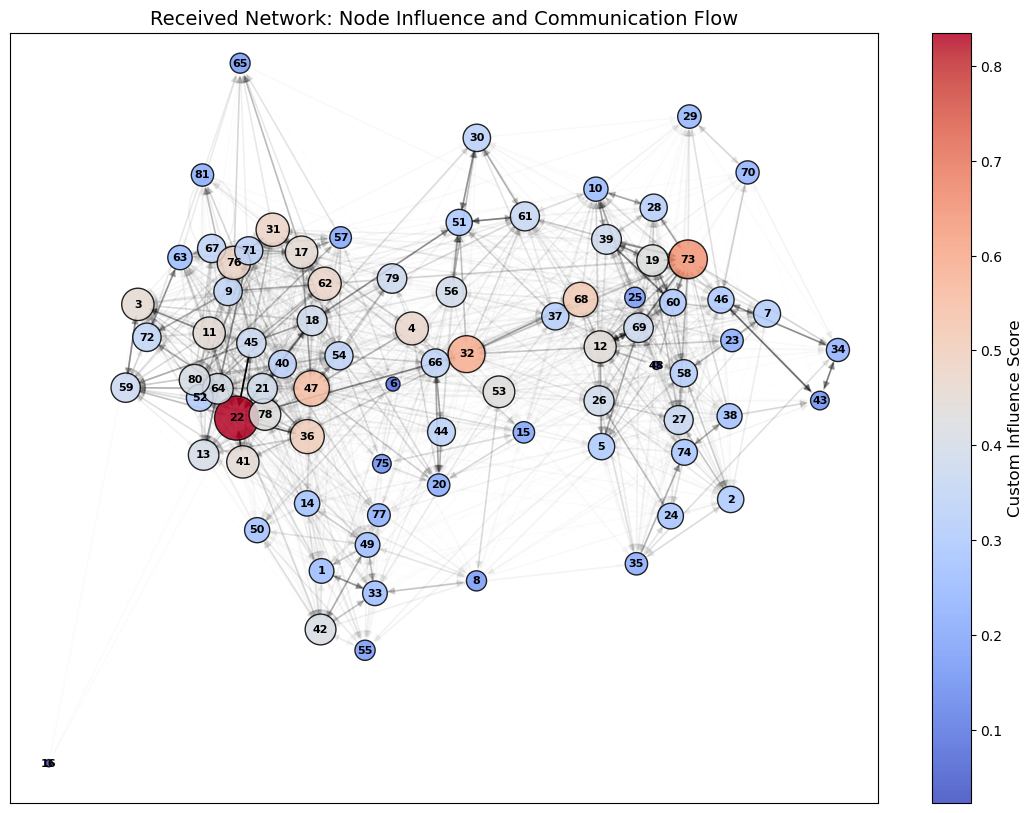

In [172]:
node_sizes = [centrality_df_norm.loc[node, "Custom Influence Score"] * 1200 for node in G_received.nodes()]
node_colors = [centrality_df_norm.loc[node, "Custom Influence Score"] for node in G_received.nodes()]

pos = nx.spring_layout(G_received, k=1, seed=42)

plt.figure(figsize=(14, 10))

edges, weights = zip(*nx.get_edge_attributes(G_received, 'weight').items())
max_weight = max(weights) if max(weights) > 0 else 1
edge_alphas = [w / max_weight for w in weights]

for edge, alpha in zip(edges, edge_alphas):
    nx.draw_networkx_edges(G_received, pos, edgelist=[edge], 
                           alpha=alpha, edge_color="black", width=1.2)

sc = nx.draw_networkx_nodes(G_received, pos, node_size=node_sizes, 
                            node_color=node_colors, cmap=plt.cm.coolwarm, 
                            alpha=0.85, edgecolors="black")

nx.draw_networkx_labels(G_received, pos, labels={node: node for node in G_received.nodes()}, 
                        font_size=8, font_weight="bold", font_color="black")

cbar = plt.colorbar(sc)
cbar.set_label("Custom Influence Score", fontsize=12)

plt.xlim(min(x for x, _ in pos.values()) * 1.1, max(x for x, _ in pos.values()) * 1.1)
plt.ylim(min(y for _, y in pos.values()) * 1.1, max(y for _, y in pos.values()) * 1.1)

plt.title("Received Network: Node Influence and Communication Flow", fontsize=14)

plt.show()

### Insights & Interpretation

The analysis of the "Received" network provides a distinct perspective on influence within the cohort by identifying individuals who are frequently contacted by others. Unlike the "Sent" network, which highlights those who initiate conversations, this network reveals key figures who are sought after for information, guidance, or decision-making. These individuals hold authority or credibility within the group, as their peers regularly engage with them.

From the custom influence score rankings, Node 22 emerges as the most influential figure, significantly outscoring others. This suggests that they are a central authority within the network, frequently consulted by their peers. Following Node 22, Nodes 73, 32, and 47 also rank highly, indicating their strong presence in incoming communication. While Node 32 was also prominent in the "Sent" network, its high influence in the "Received" sheet further reinforces its dual role as both an initiator and a focal point of communication. Other top-ranking nodes, such as 36 and 31, show strong engagement but may not have been as proactive in initiating conversations, suggesting a more authoritative or consultative role.

The network visualization supports these findings, with Nodes 22 and 73 appearing as central hubs, surrounded by multiple connections. The clustering of these nodes indicates their structural importance in the communication flow. Compared to the "Sent" network, the distribution of influence appears more fragmented, with several key figures rather than a single dominant communicator. Additionally, the positioning of Node 16 as an isolated outlier remains consistent, further reinforcing its lack of engagement in both networks.

Overall, the "Received" network sheds light on the individuals who hold implicit power within the group. These individuals may not actively shape discussions but are nonetheless critical to the network’s structure, as they act as reference points for information and decision-making. By comparing this with the "Sent" network, we can distinguish between proactive communicators and those who exert influence through their authority and perceived expertise.

## Conclusion 
This analysis provides valuable insights into the communication structure of the cohort. Opinion-makers, identified in the "Sent" network, actively drive discussions and influence the spread of information, with nodes 32, 19, and 78 emerging as the most prominent figures. Conversely, nodes 22 and 73, which dominate in the "Received" network, hold authority as trusted sources frequently consulted by their peers. Notably, both nodes 32 and 22 appear highly influential in both communication flows, establishing them as the primary leaders of the cohort.

Node 32 emerges as a pivotal figure, bridging two distinct clusters and maintaining connectivity across the network. The presence of multiple influential individuals, rather than a single dominant communicator, indicates a decentralized communication structure where influence is distributed among several key figures. Recognizing these dynamics can help organizations optimize communication strategies, strengthen collaboration, and ensure that both proactive communicators and authoritative leaders are effectively engaged in decision-making processes.